## Checks

Below we investigate checking in greyhound racing, and how it may affect the performance of a greyhound during a race.

----

### 0. Read cleansed data

In [1]:
import os
import decouple
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.ticker as plticker

from scipy.stats import zscore

config = decouple.AutoConfig(' ')
os.chdir(config('ROOT_DIRECTORY'))
sys.path.insert(0, '')

pd.set_option('display.max_columns', None)

# Read in data
df_raw = pd.read_csv('./data/clean/dog_results.csv')
df_raw['RaceDate'] = pd.to_datetime(df_raw['RaceDate'], format='%Y-%m-%d')

display(df_raw.head())

,FasttrackDogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FasttrackRaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,RaceDate
0,157500927,1,RAINE ALLEN,1,1,27.4,2.4,2.30,NaN,Q/111,0,6.68,28.66,0.0,335811282,7683,C GRENFELL,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
1,1820620018,2,SURF A LOT,2,2,32.8,6.3,2.30,2.30,M/332,0,7.01,28.82,0.0,335811282,137227,C TYLEY,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
2,1950680026,3,PINGIN' BEE,6,6,25.5,9.3,3.84,1.54,S/443,0,7.24,28.93,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
3,1524380048,4,LUCAS THE GREAT,7,7,32.2,9.1,5.27,1.43,M/655,5,7.31,29.03,0.0,335811282,116605,E HAMILTON,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
4,124225458,5,QUAVO,4,4,28.9,3.4,5.56,0.29,M/766,8,7.38,29.05,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01


### 1. SpeedNorm as a function of checks

Here we look at the average performane of a greyhound (measured using the SpeedNorm) based on the number of checks. 

Interestingly, if a greyhound experiences between 0-2 checks (inclusive) then their performance is generally unaffected (actually slightly better performance). There appears to be a significant reduction in performance once 3-6 checks are experienced, and 7+ checks showing a much larger decrease in performance.

This data could be used to correct a greyhounds recent performance (when used to predict future performance) if it had been affected (or not affected) by checking. No doubt, the average number of checks will be absorbed in box winning percentage by TrackDist, but it could be of use in predicting a greyhounds undisturbed SpeedNorm.

In [43]:
# Copy
df = df_raw.copy()

# Remove NaN tracks
df = df[~df.TrackDist.isna()]

# Create SpeedNorm column
df["Speed"] = df["Distance"]/df["RunTime"]
df["SpeedNorm"] = df.groupby("TrackDist")["Speed"].transform(lambda x: zscore(x))

# Take only columns of interest
df = df[['Checks', 'SpeedNorm']]

# Groupby number of checks and take general SpeedNorm statistics
df = df.groupby('Checks', as_index=False).agg(SpeedNorm_mean = ('SpeedNorm', 'mean'),
                                             SpeedNorm_std = ('SpeedNorm', 'std'),
                                             SampleSize = ('SpeedNorm', 'count'))

display(df.head(10))

,Checks,SpeedNorm_mean,SpeedNorm_std,SampleSize
0,0,0.089127,1.005349,515021
1,1,0.197650,0.887173,77607
2,2,0.010828,0.848615,24333
3,3,-0.163997,0.853748,4015
4,4,-0.283102,0.911286,67663
5,5,-0.329050,0.874503,33294
6,6,-0.422269,0.880546,7233
7,7,-1.191375,1.060367,6642
8,8,-0.665715,0.940537,17032
9,9,-0.619538,0.894364,5043


Let's group by these three ranges, and take the same general statistics of the SpeedNorm.

In [44]:
# Copy
df = df_raw.copy()

# Remove NaN tracks
df = df[~df.TrackDist.isna()]

# Create SpeedNorm column
df["Speed"] = df["Distance"]/df["RunTime"]
df["SpeedNorm"] = df.groupby("TrackDist")["Speed"].transform(lambda x: zscore(x))

# Take only columns of interest
df = df[['Checks', 'SpeedNorm']]

# Alter Checks column
def checks_func(check_int):
    if 0 <= check_int <= 2:
        return '0-2'
    elif 3 <= check_int <= 6:
        return '3-6'
    else:
        return '7+'
df['Checks'] = df['Checks'].apply(lambda x: checks_func(x))

# Groupby number of checks and take general SpeedNorm statistics
df = df.groupby('Checks', as_index=False).agg(SpeedNorm_mean = ('SpeedNorm', 'mean'),
                                             SpeedNorm_std = ('SpeedNorm', 'std'),
                                             SampleSize = ('SpeedNorm', 'count'))

display(df)

,Checks,SpeedNorm_mean,SpeedNorm_std,SampleSize
0,0-2,0.099690,0.986277,616961
1,3-6,-0.301445,0.897659,112205
2,7+,-0.814121,0.996283,34001


Let's have a quick look at the average number of checks a greyhound should expect to experience on any given race. It appears that (if the data is correct), that a greyhound should only expect to be checked in 25% of its races.

In [45]:
# Copy
df = df_raw.copy()

# Remove NaN tracks
df = df[~df.TrackDist.isna()]

display(df.Checks.describe())

count    763167.000000
mean          1.191119
std           2.251525
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          25.000000
Name: Checks, dtype: float64

### 2. Number of Checks by TrackDist

Let's quickly have a look at the general check statistics for each TrackDist (with a sufficiently large sample size).

It appears that some Tracks aren't recording checks (e.g. Albion Park 331). At the Track's we do have the data available, it does appear that the average number of checks does change with respect to the TrackDist. The largest being Sandown Park 515m and the smallest being Healsville 300m, we can look at races at these tracks and see why this result is plausible (given the tracks design):

Sandown 515m 26/12/21: https://www.youtube.com/watch?v=Ibt9og2K9HA&ab_channel=GRVVision

Healeville 300m 28/12/21: https://www.youtube.com/watch?v=zrqhk4XApGw&ab_channel=GRVVision

,TrackDist,Checks_mean,Checks_std,Checks_SampleSize
0,Ballarat390,2.431377,2.541767,16445
1,Ballarat450,2.457772,2.650606,15523
2,Bendigo425,2.202202,2.496339,23160
3,Bendigo500,2.248752,2.447872,9415
4,Cranbourne311,2.591213,2.693428,19597
5,Cranbourne520,2.875960,2.970089,7030
6,Geelong400,2.433615,2.501093,17647
7,Geelong460,2.478914,2.637717,11524
8,Healesville300,1.905341,2.396407,18815
9,Healesville350,2.025159,2.487272,18125


<AxesSubplot:xlabel='TrackDist', ylabel='Checks_mean'>

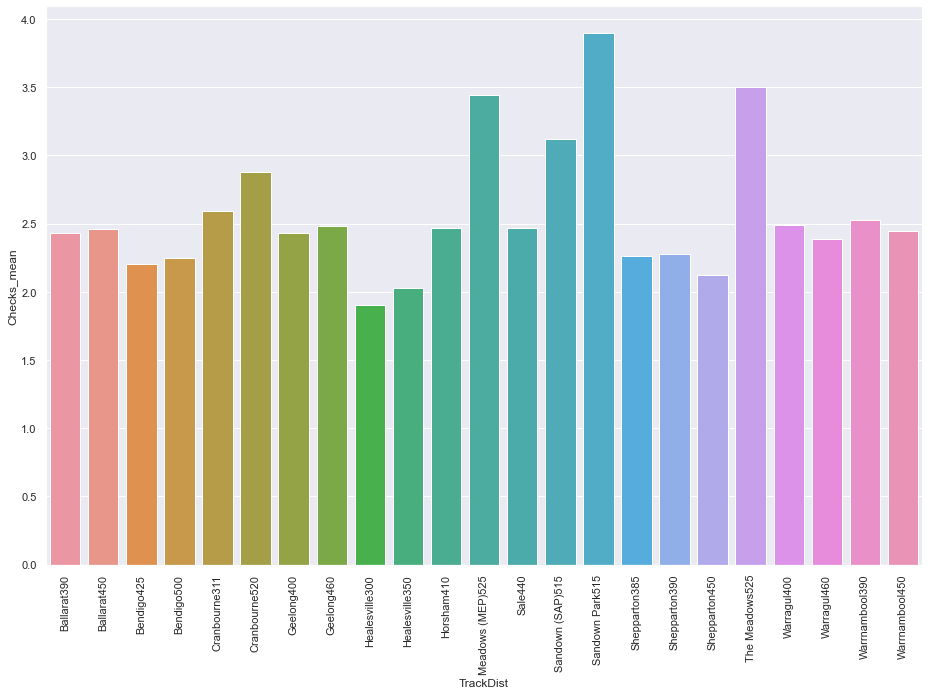

In [46]:
# Copy
df = df_raw.copy()

# Remove NaN tracks
df = df[~df.TrackDist.isna()]

# Group by box and count the number of checks
df = df.groupby(['TrackDist'], as_index=False).agg(Checks_mean = ('Checks', 'mean'),
                                                         Checks_std = ('Checks', 'std'),
                                                         Checks_SampleSize = ('Checks', 'count'))

# Sufficient sample size
df = df[df['Checks_SampleSize'] >= 5000]

# Take only TrackDist with data recorded
df = df[df['Checks_std'] != 0].reset_index(drop=True)

display(df)

# plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(15.7, 10.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)
plt.xticks(rotation=90)
sns.barplot(data=df, x="TrackDist", y="Checks_mean")